# **Project: Predict Default Account**
# Introduction

Financial institutions utilize statistical and machine learning models to determine whether they approve or decline applications for credit products such as credit cards and home loans. whether an account may become default or not after its approval and opening provides important information for risk control. If the applicant is more likely to have a default account, more strict requirements may be used for aprroving new credit products. 

# Objective
To develop two binary classification models (Logistic Regression and XGBoost) for predicting default accounts with 20 relevant explanatory variables. 

# Contents
* Exploratory Data Analysis
* Data Cleaning
* Multicollinearity
* Model Building 
* Model Performance
* Variable Importance and Effect (pdp, SHAP)
* Summary

# Data Description
* Training set: 20000 X 20
* Test set: 5000 X 20 
* Variable information table:

| Variable Notation | Description | Type |
| --- | --- |--- |
| TB | Total balance for all credit products | Continuous |
| ABC | Average balance for all cards | Continuous |
| CA | Age of the first obtained credit product | Continuous |
| CAG | Age of the oldest good credit product | Continuous |
| CCA | Age of the oldest credit card | Continuous |
| ND12 | # of account (≥30 days delinquent, 21 months) | Continuous |
| ND6| # of account (≥30 days delinquent, 6 months) | Continuous |
| NMD | # of mortgages (delinquent, 6 months) | Continuous |
| TAD | Total amount past due (all credit account) | Continuous |
| NI12 | # of inquires in last 12 months | Continuous |
| NCI24| # of credit card inquires, last 24 months | Continuous |
| NCI12| # of credit cards opened, last 12 months | Continuous |
| NA36 | # of auto loans opened, last 36 months | Continuous |
| UOC | Utilization on open credit card amounts | Continuous |
| PO50 | % of account with >50% utilization | Continuous |
| UMC | Utilization of credit account with max limit | Continuous |
| PC50 | % of credit cards with >50% utilization | Continuous |
| IND | Binary, already holding accounts | Categorical |
| RI | Represented income (annual) | Continuous |
| RE | Represented education level (4 levels) | Categorical |
| DI | Defaulted index, binary, account defaulted in past 18 months | Categorical |


In [90]:
library(tidyverse) 
library(caret) #for Data splitting
library(mice)
library(VIM) #for plot missing data patterns
library(glmnet) # for lasso and ridge regularization
library(pROC) #For AUC calculation
library(xgboost) 
library(pdp) #for PCA
library(car) # for VIF
library(SHAPforxgboost) # for shapley value
library(DiagrammeR)

# Load the Data

In [22]:
df <- read_csv("/content/Train.csv")
head(df)
test <- read_csv("/content/Test.csv")
head(test)

Rows: 20000 Columns: 21
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): RE
dbl (20): TB, ABC, CA, CAG, CCA, ND12, ND6, NMD, TAD, NI12, NCI24, NC12, NA3...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


TB,ABC,CA,CAG,CCA,ND12,ND6,NMD,TAD,NI12,⋯,NC12,NA36,UOC,PO50,UMC,PC50,IND,RI,RE,DI
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
102956.11,14819.06,238,104,264,0,0,0,0,0,⋯,1,0,0.3667370,0.3421834,0.5139336,0.5508660,0,118266.32,college,0
132758.73,18951.93,384,197,371,0,0,0,0,0,⋯,0,0,0.4908088,0.5406713,0.4180161,NA,0,89365.06,college,0
124658.92,15347.93,277,110,288,0,0,0,0,0,⋯,0,0,0.3590741,0.3385601,0.3416270,0.4514175,0,201365.12,college,0
133968.54,14050.71,375,224,343,0,0,0,0,2,⋯,1,0,0.7003788,0.6835888,0.5429404,0.6078426,0,191794.49,college,0
143601.80,14858.52,374,155,278,0,0,0,0,0,⋯,0,0,0.6473510,0.5108120,0.6329341,0.5736799,0,161465.37,graduate,0
83980.69,8505.41,250,178,255,1,0,0,0,0,⋯,0,0,0.6020827,0.4932983,0.6972541,NA,0,145392.18,college,0


Rows: 5000 Columns: 21
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): RE
dbl (20): TB, ABC, CA, CAG, CCA, ND12, ND6, NMD, TAD, NI12, NCI24, NC12, NA3...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


TB,ABC,CA,CAG,CCA,ND12,ND6,NMD,TAD,NI12,⋯,NC12,NA36,UOC,PO50,UMC,PC50,IND,RI,RE,DI
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
75061.45,11051.42,191,103,220,0,0,0,0,0,⋯,0,0,0.4171164,0.4908091,0.4003795,0.4294272,1,200322.0,high_school,0
89792.75,13839.38,140,145,152,1,0,0,0,0,⋯,0,1,0.4721165,0.5055810,0.6555168,0.5012789,0,168453.0,high_school,0
95928.23,10437.19,343,220,388,2,0,0,19531,0,⋯,0,1,0.3940994,0.5515389,0.3096630,0.4829152,1,190634.0,other,0
124957.43,17413.11,232,97,235,0,0,0,0,0,⋯,2,1,0.4928459,0.5401088,0.5904570,0.4662238,1,106712.6,high_school,0
75058.13,12326.24,236,165,280,0,0,0,0,0,⋯,1,1,0.3814522,0.3447723,0.5265553,0.3454552,0,173172.2,college,0
95956.63,14480.23,328,213,335,0,0,0,0,0,⋯,0,1,0.3083895,0.4389040,0.4189275,0.3698520,1,158710.0,graduate,0


# Training/Validation Split

In [388]:
set.seed(1)
training.samples <- df$DI %>% createDataPartition(p = 0.8, list = FALSE)
train <- df[training.samples, ] # training set 80%
val <- df[-training.samples, ] # validation set 20%

paste("Training set dimension:")
dim(train)
paste("Validation set dimension:")
dim(val)

[1] "Training set dimension:"

[1] 16000    21

[1] "Validation set dimension:"

[1] 4000   21

# Exploratory Data Analysis

## Data Summary

In [187]:
trainc <- train # create a copy 
trainc$ND12 <- factor(trainc$ND12)
trainc$ND6 <- factor(trainc$ND6)
trainc$ NMD <- factor(trainc$NMD)
trainc$NC12 <- factor(trainc$NC12)
trainc$NA36 <- factor(trainc$NA36)
trainc$IND <- factor(trainc$IND)
trainc$RE <- factor(trainc$RE)
trainc$DI <- factor(trainc$DI)
trainc_x_continuous <- trainc[,c(1,2,3,4,5,9,10,11,14,15,16,17,19)]

# Data summary for continuous variables
summary(trainc_x_continuous)
sd <- round(apply(trainc_x_continuous, 2, sd, na.rm =TRUE),1)

       TB              ABC              CA             CAG       
 Min.   :     0   Min.   :    0   Min.   :  0.0   Min.   :  0.0  
 1st Qu.: 92216   1st Qu.:10171   1st Qu.:232.0   1st Qu.:120.0  
 Median :107620   Median :12253   Median :281.0   Median :146.0  
 Mean   :107360   Mean   :12234   Mean   :280.8   Mean   :146.1  
 3rd Qu.:122635   3rd Qu.:14271   3rd Qu.:330.0   3rd Qu.:172.0  
 Max.   :200000   Max.   :25000   Max.   :550.0   Max.   :300.0  
                                                                 
      CCA             TAD               NI12            NCI24       
 Min.   :  0.0   Min.   :    0.0   Min.   : 0.000   Min.   : 0.000  
 1st Qu.:242.0   1st Qu.:    0.0   1st Qu.: 0.000   1st Qu.: 0.000  
 Median :285.0   Median :    0.0   Median : 0.000   Median : 0.000  
 Mean   :285.3   Mean   :  359.5   Mean   : 0.612   Mean   : 1.046  
 3rd Qu.:330.0   3rd Qu.:    0.0   3rd Qu.: 1.000   3rd Qu.: 1.000  
 Max.   :524.0   Max.   :30669.9   Max.   :10.000   Max.  

In [25]:
# Frequency counts for categorical variables
summary(trainc[,-c(1,2,3,4,5,9,10,11,14,15,16,17,19)]) 

 ND12      ND6       NMD       NC12      NA36      IND                 RE      
 0:14058   0:15531   0:15505   0:11922   0:13417   0:11992   college    :9715  
 1: 1429   1:  451   1:  495   1: 3778   1: 2546   1: 4008   graduate   :1906  
 2:  431   2:   18             2:  294   2:   37             high_school:4262  
 3:   74                       3:    6                       other      : 117  
 4:    6                                                                       
 5:    2                                                                       
 DI       
 0:14386  
 1: 1614  
          
          
          
          

Imbalanced classes with 14386 and 1614 for the 0 and 1 classes, respectively.

## Exploratory Plots

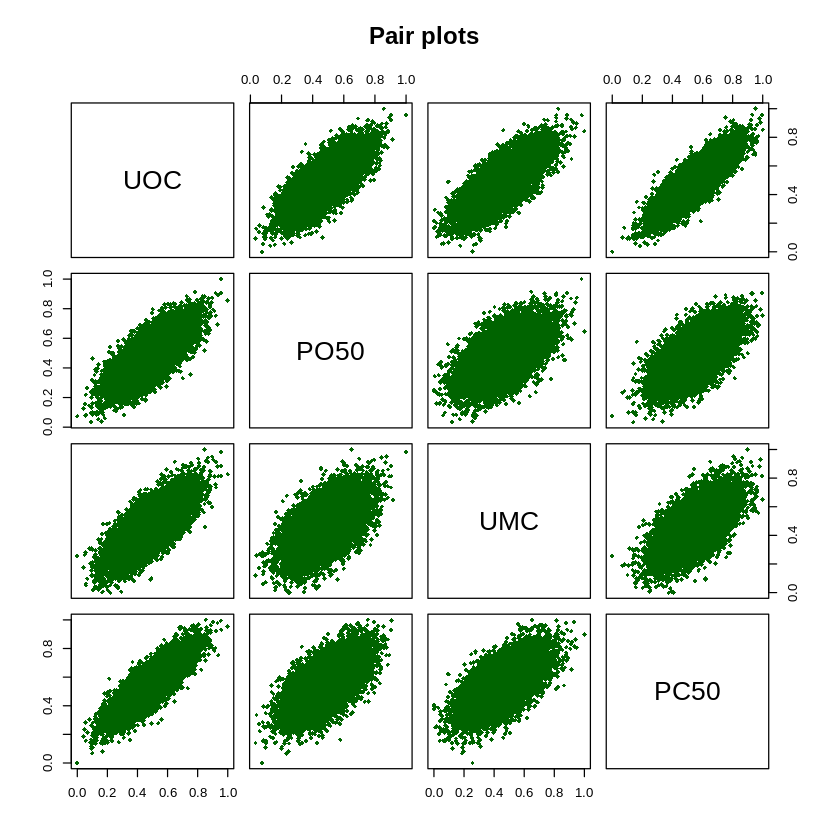

In [26]:
# Paied plots for some continuous variables
pairs(train[,c(14, 15, 16, 17)], cex = 0.8, col = "darkgreen", pch = 18, 
      main = " Pair plots")

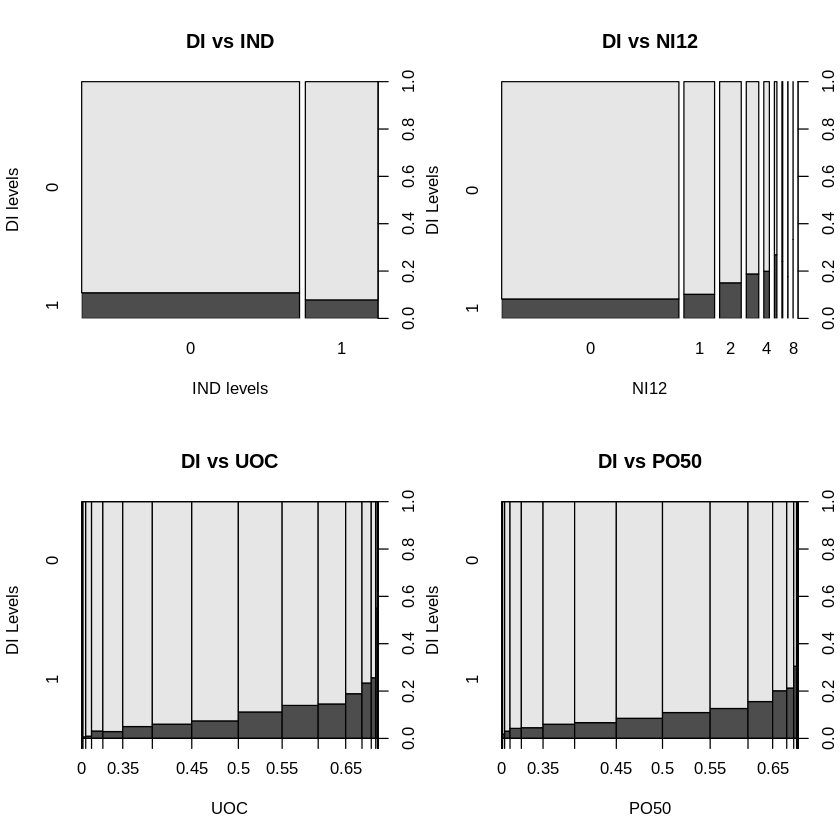

In [347]:
# DI (default index) vs some variables
par(mfrow = c(2, 2))
plot(factor(DI) ~ factor(IND), data =train, 
     ylab="DI levels", xlab="IND levels", main="DI vs IND")

plot(factor(DI) ~ factor(NI12), data =train,
     xlab = 'NI12', ylab ='DI Levels', main="DI vs NI12")

plot(factor(DI) ~ UOC, data =train, 
     xlab = 'UOC', ylab ='DI Levels', main="DI vs UOC")

plot(factor(DI) ~ (PO50), data =train,
      xlab = 'PO50', ylab ='DI Levels', main="DI vs PO50")

# Data Cleaning

## Missing Data Percentage

In [28]:
pMiss <- function(x){
  sum(is.na(x))/length(x)*100}

miss_tr <- round(sort(apply(train,2,pMiss), decreasing =TRUE),2)
miss_val <- round(sort(apply(val,2,pMiss), decreasing =TRUE),2)
miss_ts <- round(sort(apply(test,2,pMiss), decreasing =TRUE),2)
paste("Missing data % for training set:")
as.table(miss_tr)
paste("Missing data % for validation set:")
as.table(miss_val)
paste("Missing data % for test set:")
as.table(miss_ts)

[1] "Missing data % for training set:"

 PC50    RI    TB   ABC    CA   CAG   CCA  ND12   ND6   NMD   TAD  NI12 NCI24 
 9.76  7.75  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
 NC12  NA36   UOC  PO50   UMC   IND    RE    DI 
 0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

[1] "Missing data % for validation set:"

 PC50    RI    RE    TB   ABC    CA   CAG   CCA  ND12   ND6   NMD   TAD  NI12 
 9.93  7.98  0.03  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
NCI24  NC12  NA36   UOC  PO50   UMC   IND    DI 
 0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

[1] "Missing data % for test set:"

 PC50    RI    RE    TB   ABC    CA   CAG   CCA  ND12   ND6   NMD   TAD  NI12 
 9.78  8.20  0.08  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
NCI24  NC12  NA36   UOC  PO50   UMC   IND    DI 
 0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00 

## Missing Data Plot

[1] "Missing data for training set:"


 Variables sorted by number of missings: 
 Variable     Count
     PC50 0.0975625
       RI 0.0775000


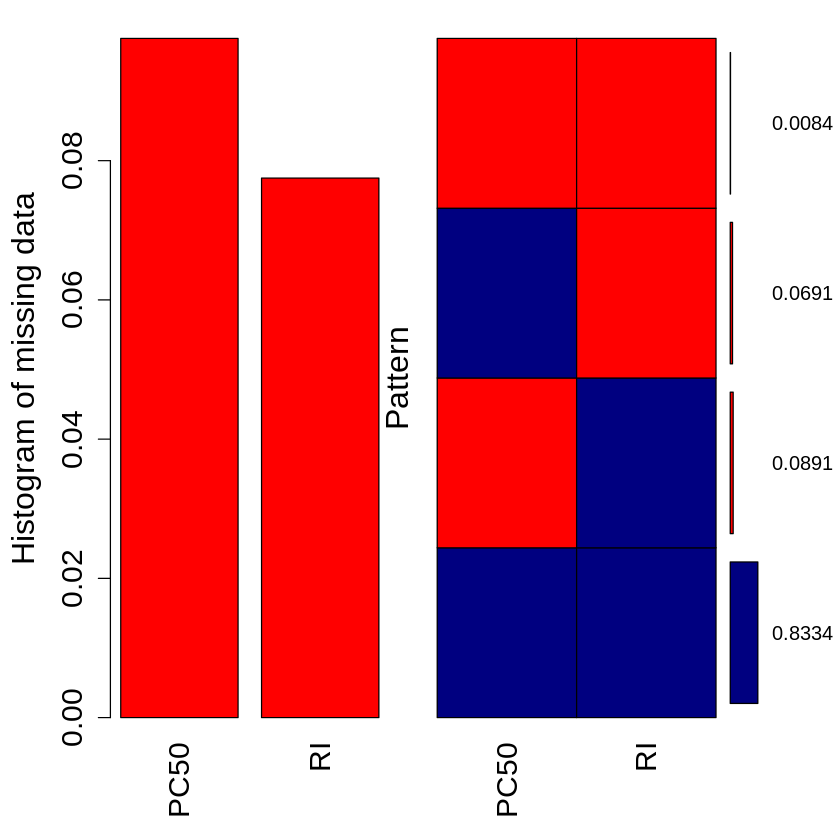

In [323]:
paste("Missing data for training set:")
aggr(train[which(apply(train,2,pMiss) > 0)], col=c('navyblue','red'), 
numbers=TRUE, sortVars=TRUE, labels=names(train[which(apply(train,2,pMiss) > 0)]), 
cex.axis=1.5, cex.lab = 1.6, gap=2, ylab=c("Histogram of missing data","Pattern"))

In [ ]:
# Missing data plots for trainging set (similar results)
paste("Missing data for validation set:")
aggr(val[which(apply(val,2,pMiss) > 0)], col = c('navyblue','red'), numbers = TRUE, 
sortVars = TRUE, labels = names(val[which(apply(val,2,pMiss) > 0)]), cex.axis = 0.5, 
gap = 2, ylab = c("Histogram of missing data","Pattern"))

In [ ]:
# Missing data plots for trainging set (similar result)
paste("Missing data for test set:")
aggr(test[which(apply(test,2,pMiss)>0)], col = c('navyblue','red'), numbers = TRUE, 
sortVars = TRUE, labels=names(test[which(apply(test,2,pMiss)>0)]), cex.axis = 0.5, 
gap=2, ylab=c("Histogram of missing data","Pattern"))

## Data Imputation

In [ ]:
# Impute missing data with mice package (continuous) or mode (categorical) 

train2 <- subset(train, select = -c(RE, IND,DI))
val2 <- subset(val, select = -c(RE, IND,DI))
test2 <- subset(test, select = -c(RE, IND,DI))

# Impute continuous data - training
tempData <- mice(train2, m = 5,maxit = 50, meth = 'pmm',seed = 500)
completedData <- complete(tempData,1)
train3<-as_tibble(cbind(completedData,train[, which(names(train) %in% 
                                                      c('RE', 'IND','DI'))]))
train3$IND  <- factor(train3$IND)
X_train =  train3[,-21]
y_train = train3$DI

# Impute continuous data - validation
tempData_val <- mice(val2,m = 5,maxit = 50,meth = 'pmm',seed = 500)
completedData <- complete(tempData_val,1)
val3 <- as_tibble(cbind(completedData,val[, which(names(val) %in% 
                                                  c('RE', 'IND','DI'))]))

# Impute categorical data - validation
val3$RE[is.na(val3$RE)] <- names(which.max(table(val3$RE)))

val3$IND  <- factor(val3$IND)
X_val =  val3[,-21]
y_val = val3$DI

# Impute continuous data - test
tempData <- mice(test2,m = 5,maxit = 50,meth = 'pmm',seed = 500)
completedData <- complete(tempData,1)
test3 <- as_tibble(cbind(completedData,test[, which(names(test) %in% 
                                                    c('RE', 'IND','DI'))]))

# # Impute categorical data - test
test3$RE[is.na(test3$RE)] <- names(which.max(table(test3$RE)))

test3$IND  <- factor(test3$IND)
X_test =  test3[,-21]
y_test = test3$DI

# Multicollinearity

## VIF

In [395]:
# Keep continuous x variables
X_trainc <- subset(X_train, select = -c(RE, IND))

# Check VIFs <10
VIF <- as.table(round(diag(solve(cor(X_trainc))),2))
paste ("VIF values:")
VIF

[1] "VIF values:"

   TB   ABC    CA   CAG   CCA  ND12   ND6   NMD   TAD  NI12 NCI24  NC12  NA36 
 1.99  1.99  5.40  2.74  3.60  3.19  3.05  3.03  4.12  5.42  5.42  1.02  1.01 
  UOC  PO50   UMC  PC50    RI 
 6.16  2.28  2.31  3.57  1.00 

## Condition Number

In [326]:
# Check condition number
scale.x = scale(X_trainc)
e = eigen(t(scale.x)%*%scale.x)

paste("Condition number:")
round(sqrt(max(e$values)/min(e$values)), 2) 
# <30, no serious multi-collinearity problem

[1] "Condition number:"

[1] 5.92

# 1. Logistic Regression 
Since the response DI classes are imbalanced (14386: 1614), class weights are assigned for the classes. And two methods for feature selection are used including (1) Lasso Regularization with Cross Validation (CV), and (2) Stepwise selection with the AIC criterion. 

## Method (1): Lasso Regularization with CV

## Find the Best Lambda

[1] "Best lambda = 0.0022"

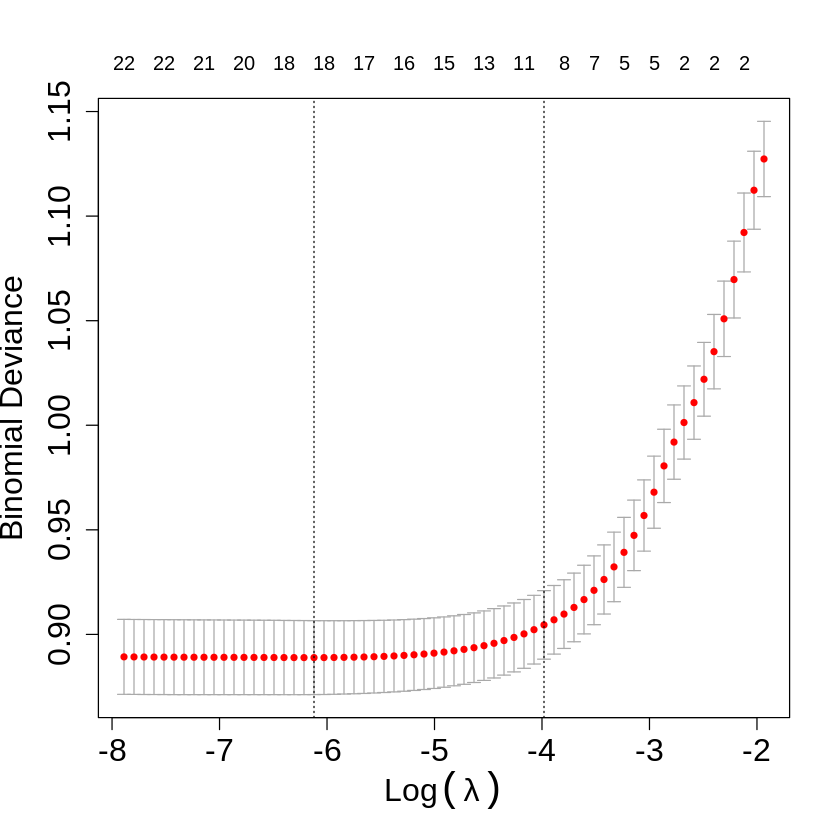

In [354]:
# One-hot emcoding for categorical variables
x_mtx <- model.matrix( ~.-1, X_train) 
xt_mtx <- model.matrix( ~.-1, X_test)
xv_mtx <- model.matrix( ~.-1, X_val)

# Class weights
model_weights <- ifelse(train3$DI == "0", 1, round(sqrt(table(y_train)[1]/table(y_train)[2])))

# Lasso regularization and cv
set.seed(123) 
cv.lasso <- cv.glmnet(x_mtx, factor(y_train), 
                      weights = model_weights, intercept = TRUE, alpha = 1, 
                      family = "binomial", nfolds = 5) 

plot(cv.lasso, cex.lab = 1.6, cex.axis = 1.6, cex.main = 1.6, cex.sub = 1.6)
best_lambda <- (cv.lasso$lambda.min)
paste("Best lambda =", round(best_lambda,5))

## Fit Model

In [389]:
# Variables selected
varible_slct <- which(cv.lasso$glmnet.fit$beta[,which(cv.lasso$cvm == min(cv.lasso$cvm))] != 0)
paste ("Total number of selected variables =", length(varible_slct))
paste("Selected variables:")
as.table(varible_slct)

# Fit model on training set
model <- glmnet(x_mtx, y_train, alpha = 1, weights = model_weights,
                family = "binomial",
                lambda = best_lambda)

[1] "Total number of selected variables = 18"

[1] "Selected variables:"

           TB           ABC            CA           CCA          ND12 
            1             2             3             5             6 
          ND6           NMD          NI12          NC12           UOC 
            7             8            10            12            14 
         PO50           UMC            RI          IND0          IND1 
           15            16            18            19            20 
   REgraduate REhigh_school       REother 
           21            22            23 

## Model Coefficients

In [390]:
# Model coefficients
paste("Coeffecients:")
round(coef(model), 5)

[1] "Coeffecients:"

24 x 1 sparse Matrix of class "dgCMatrix"
                    s0
(Intercept)   -2.44219
TB             0.00000
ABC           -0.00011
CA            -0.00420
CAG            .      
CCA           -0.00014
ND12           0.91392
ND6            0.50377
NMD            0.29607
TAD            .      
NI12           0.23660
NCI24          .      
NC12           0.18847
NA36           .      
UOC            4.95809
PO50           0.67898
UMC            0.30795
PC50           .      
RI             0.00000
IND0           0.29023
IND1           0.00000
REgraduate    -0.13208
REhigh_school  0.10476
REother       -0.39872

## Model Performance

In [391]:
# Model prediction on training, validation, and test sets
prob_train <- model %>% predict(s = 'lambda.min', newx = x_mtx, type = "response")
pred.c_train <- ifelse(prob_train >= 0.5, 1, 0)
prob_val <- model %>% predict(s = 'lambda.min', newx = xv_mtx, type = "response")
pred.c_val <- ifelse(prob_val >= 0.5, 1, 0)
prob_test <- model %>% predict(s = 'lambda.min', newx = xt_mtx, type = "response")
pred.c_test <- ifelse(prob_test >= 0.5, 1, 0)

# Confusion matrix 
confusionMatrix(factor(pred.c_train), factor(y_train), mode = "everything", positive = "1")
confusionMatrix(factor(pred.c_val), factor(y_val), mode = "everything", positive = "1")
confusionMatrix(factor(pred.c_test), factor(y_test), mode = "everything", positive = "1")

# Model AUC
paste ("AUC for training set = ", auc(y_train, as.vector(prob_train)))
paste ("AUC for validation set = ", auc(y_val, as.vector(prob_val)))
paste ("AUC for test set = ", auc(y_test, as.vector(prob_test)))

Confusion Matrix and Statistics

          Reference
Prediction     0     1
         0 13676  1023
         1   710   591
                                          
               Accuracy : 0.8917          
                 95% CI : (0.8868, 0.8965)
    No Information Rate : 0.8991          
    P-Value [Acc > NIR] : 0.9991          
                                          
                  Kappa : 0.3467          
                                          
 Mcnemar's Test P-Value : 6.644e-14       
                                          
            Sensitivity : 0.36617         
            Specificity : 0.95065         
         Pos Pred Value : 0.45427         
         Neg Pred Value : 0.93040         
              Precision : 0.45427         
                 Recall : 0.36617         
                     F1 : 0.40549         
             Prevalence : 0.10088         
         Detection Rate : 0.03694         
   Detection Prevalence : 0.08131         
      Balanced Acc

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 3447  253
         1  167  133
                                          
               Accuracy : 0.895           
                 95% CI : (0.8851, 0.9043)
    No Information Rate : 0.9035          
    P-Value [Acc > NIR] : 0.9664          
                                          
                  Kappa : 0.3313          
                                          
 Mcnemar's Test P-Value : 3.36e-05        
                                          
            Sensitivity : 0.34456         
            Specificity : 0.95379         
         Pos Pred Value : 0.44333         
         Neg Pred Value : 0.93162         
              Precision : 0.44333         
                 Recall : 0.34456         
                     F1 : 0.38776         
             Prevalence : 0.09650         
         Detection Rate : 0.03325         
   Detection Prevalence : 0.07500         
      Balanced Accuracy 

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 4042  268
         1  458  232
                                          
               Accuracy : 0.8548          
                 95% CI : (0.8447, 0.8645)
    No Information Rate : 0.9             
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.3099          
                                          
 Mcnemar's Test P-Value : 2.309e-12       
                                          
            Sensitivity : 0.4640          
            Specificity : 0.8982          
         Pos Pred Value : 0.3362          
         Neg Pred Value : 0.9378          
              Precision : 0.3362          
                 Recall : 0.4640          
                     F1 : 0.3899          
             Prevalence : 0.1000          
         Detection Rate : 0.0464          
   Detection Prevalence : 0.1380          
      Balanced Accuracy 

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "AUC for training set =  0.799351557026305"

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "AUC for validation set =  0.790265117519376"

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "AUC for test set =  0.791149333333333"

## Method (2): Stepwise Selection with AIC

## Model Selection

In [ ]:
# Fit model
model_weights <- ifelse(train3$DI == "0", 1, round(sqrt(table(y_train)[1]/table(y_train)[2])))
fullmodel <- glm(DI ~., weights = model_weights, data = train3, family = 'binomial')
step(fullmodel) # long stepwise model selection, not shown

## Model Summary

In [333]:
# Selected model
model2 <- glm(DI ~ ABC + CA + CAG + ND12 + ND6 + NMD + NI12 + NCI24 + NC12 +
              UOC + PO50 + UMC + IND + RE, 
             family = "binomial", weights = model_weights, data = train3) 

summary(model2)


Call:
glm(formula = DI ~ ABC + CA + CAG + ND12 + ND6 + NMD + NI12 + 
    NCI24 + NC12 + UOC + PO50 + UMC + IND + RE, family = "binomial", 
    data = train3, weights = model_weights)

Coefficients:
                Estimate Std. Error z value Pr(>|z|)    
(Intercept)   -2.213e+00  1.401e-01 -15.800  < 2e-16 ***
ABC           -1.200e-04  5.859e-06 -20.483  < 2e-16 ***
CA            -4.866e-03  4.379e-04 -11.110  < 2e-16 ***
CAG            7.792e-04  8.215e-04   0.949  0.34282    
ND12           9.260e-01  5.222e-02  17.733  < 2e-16 ***
ND6            5.551e-01  1.341e-01   4.139 3.48e-05 ***
NMD            3.210e-01  1.412e-01   2.274  0.02299 *  
NI12           3.178e-01  3.599e-02   8.831  < 2e-16 ***
NCI24         -4.344e-02  2.040e-02  -2.130  0.03320 *  
NC12           2.199e-01  3.772e-02   5.830 5.53e-09 ***
UOC            5.055e+00  2.856e-01  17.700  < 2e-16 ***
PO50           7.458e-01  2.361e-01   3.160  0.00158 ** 
UMC            3.615e-01  2.222e-01   1.627  0.10366    
IND

In [334]:
# Check collinearity again
vif(model2)
# All vif <3, no serious collinearity issue

,GVIF,Df,GVIF^(1/(2*Df))
ABC,1.011103,1,1.005536
CA,2.669391,1,1.633827
CAG,2.668591,1,1.633582
ND12,2.448622,1,1.564807
ND6,2.479987,1,1.574798
NMD,2.725962,1,1.651049
NI12,6.291595,1,2.508305
NCI24,6.285191,1,2.507028
NC12,1.001771,1,1.000885
UOC,3.224863,1,1.795790


## Check Outliers

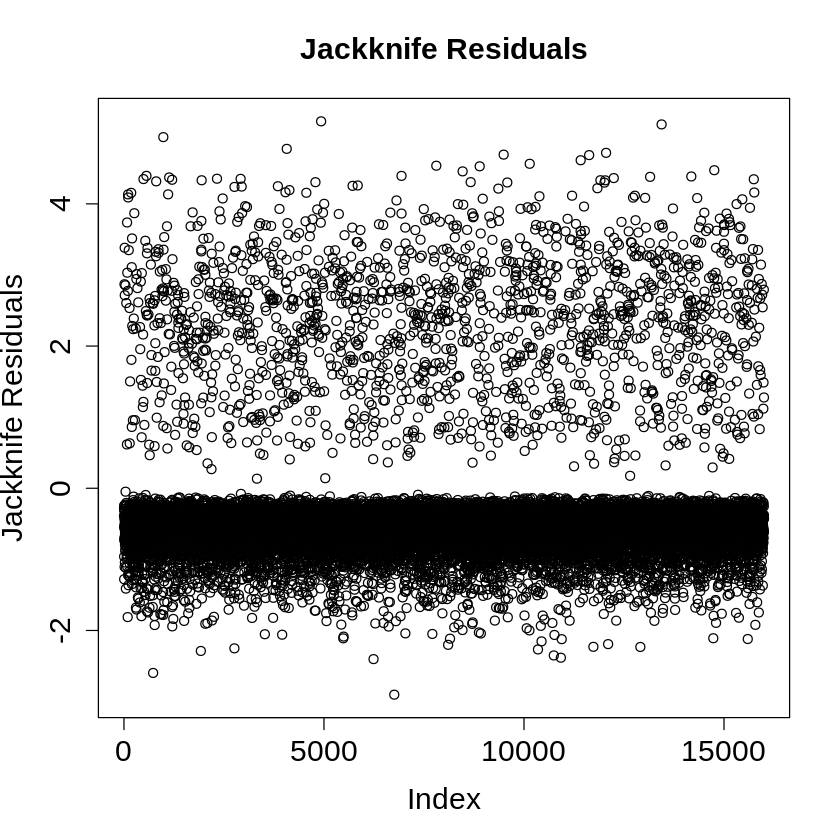

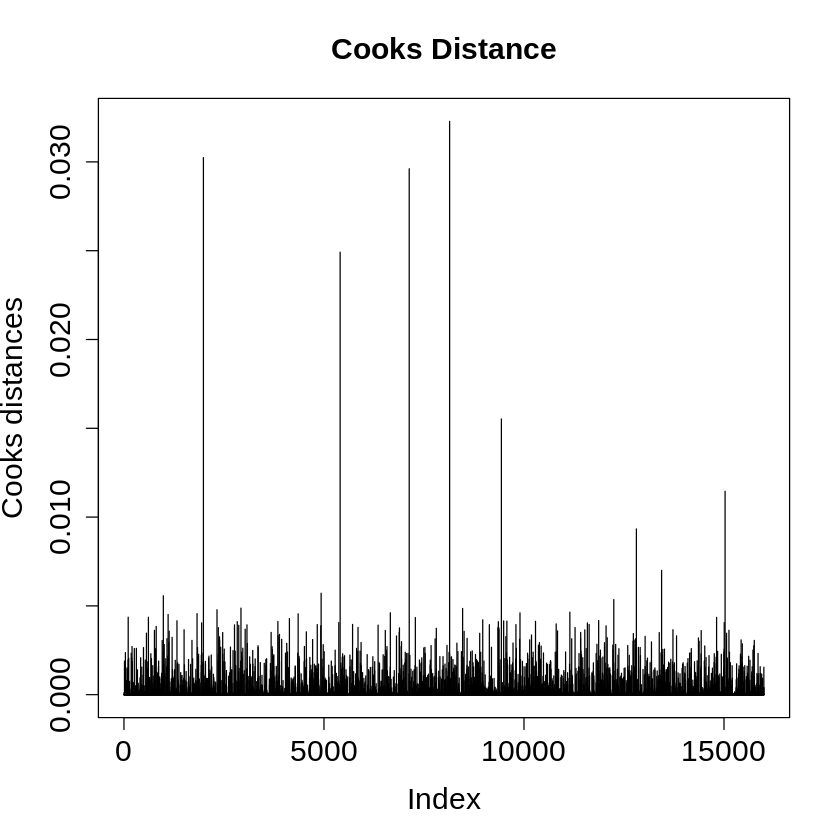

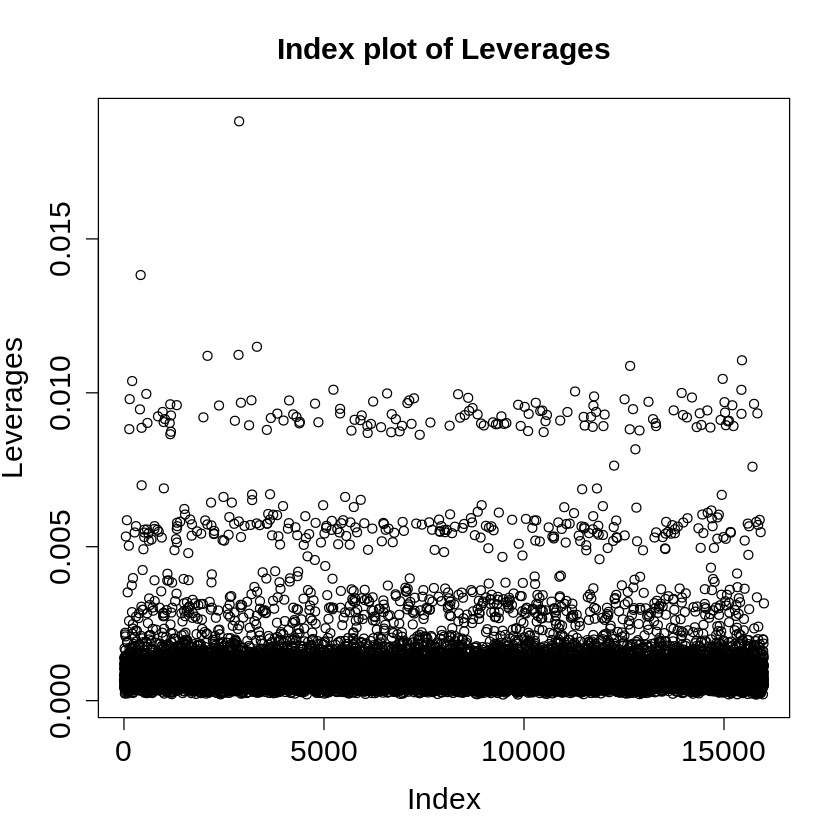

In [378]:
# Check Outliers
index <- row.names(train3)
jack <- rstudent(model2)

# Cook Statistics
index <- row.names(train3)
cook <- cooks.distance(model2)

# Leverage
x <- model.matrix(model2)
lev <- hat(x)

par(mfrow = c(1, 1))
plot(jack,ylab = "Jackknife Residuals",main="Jackknife Residuals",
cex.lab = 1.5, cex.axis = 1.5, cex.main = 1.5, cex.sub = 1.5)
plot(cook,ylab = "Cooks distances",type = "h", main = "Cooks Distance",
cex.lab = 1.5, cex.axis = 1.5, cex.main = 1.5, cex.sub = 1.5)
plot(lev,ylab="Leverages",main="Index plot of Leverages",
cex.lab = 1.5, cex.axis = 1.5, cex.main = 1.5, cex.sub = 1.5)

## Model Performance

In [337]:
# Model prediction on training, validation, and test sets
prob_train2 <- predict (model2, X_train, type = "response")
prob_val2 <- predict (model2, X_val, type = "response")
prob_test2 <- predict (model2, X_test, type = "response")
pred.c_train2 <- ifelse(prob_train2 >= 0.5, 1, 0)
pred.c_val2 <- ifelse(prob_val2 >= 0.5, 1, 0)
pred.c_test2 <- ifelse(prob_test2 >= 0.5, 1, 0)

# Confusion matrix 
confusionMatrix(factor(pred.c_train2), factor(y_train), mode = "everything", positive = "1")
confusionMatrix(factor(pred.c_val2), factor(y_val), mode = "everything", positive = "1")
confusionMatrix(factor(pred.c_test2), factor(y_test), mode = "everything", positive = "1")

# Model AUC
paste ("AUC for training set = ", auc(y_train, as.vector(prob_train2)))
paste ("AUC for validation set = ", auc(y_val, as.vector(prob_val2)))
paste ("AUC for test set = ", auc(y_test, as.vector(prob_test2)))

Confusion Matrix and Statistics

          Reference
Prediction     0     1
         0 13620  1017
         1   766   597
                                          
               Accuracy : 0.8886          
                 95% CI : (0.8836, 0.8934)
    No Information Rate : 0.8991          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.3401          
                                          
 Mcnemar's Test P-Value : 3.208e-09       
                                          
            Sensitivity : 0.36989         
            Specificity : 0.94675         
         Pos Pred Value : 0.43800         
         Neg Pred Value : 0.93052         
              Precision : 0.43800         
                 Recall : 0.36989         
                     F1 : 0.40107         
             Prevalence : 0.10088         
         Detection Rate : 0.03731         
   Detection Prevalence : 0.08519         
      Balanced Acc

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 3435  251
         1  179  135
                                          
               Accuracy : 0.8925          
                 95% CI : (0.8825, 0.9019)
    No Information Rate : 0.9035          
    P-Value [Acc > NIR] : 0.9906370       
                                          
                  Kappa : 0.3275          
                                          
 Mcnemar's Test P-Value : 0.0006172       
                                          
            Sensitivity : 0.34974         
            Specificity : 0.95047         
         Pos Pred Value : 0.42994         
         Neg Pred Value : 0.93190         
              Precision : 0.42994         
                 Recall : 0.34974         
                     F1 : 0.38571         
             Prevalence : 0.09650         
         Detection Rate : 0.03375         
   Detection Prevalence : 0.07850         
      Balanced Accuracy 

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 4025  263
         1  475  237
                                          
               Accuracy : 0.8524          
                 95% CI : (0.8423, 0.8621)
    No Information Rate : 0.9             
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.31            
                                          
 Mcnemar's Test P-Value : 8.036e-15       
                                          
            Sensitivity : 0.4740          
            Specificity : 0.8944          
         Pos Pred Value : 0.3329          
         Neg Pred Value : 0.9387          
              Precision : 0.3329          
                 Recall : 0.4740          
                     F1 : 0.3911          
             Prevalence : 0.1000          
         Detection Rate : 0.0474          
   Detection Prevalence : 0.1424          
      Balanced Accuracy 

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "AUC for training set =  0.799624609220964"

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "AUC for validation set =  0.789475155626794"

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "AUC for test set =  0.791241777777778"

## Distribution of Predicted Values

[1] "Range of predicted values:"

[1] 0.01 1.00

[1] "Median of predicted values:"

[1] 0.18

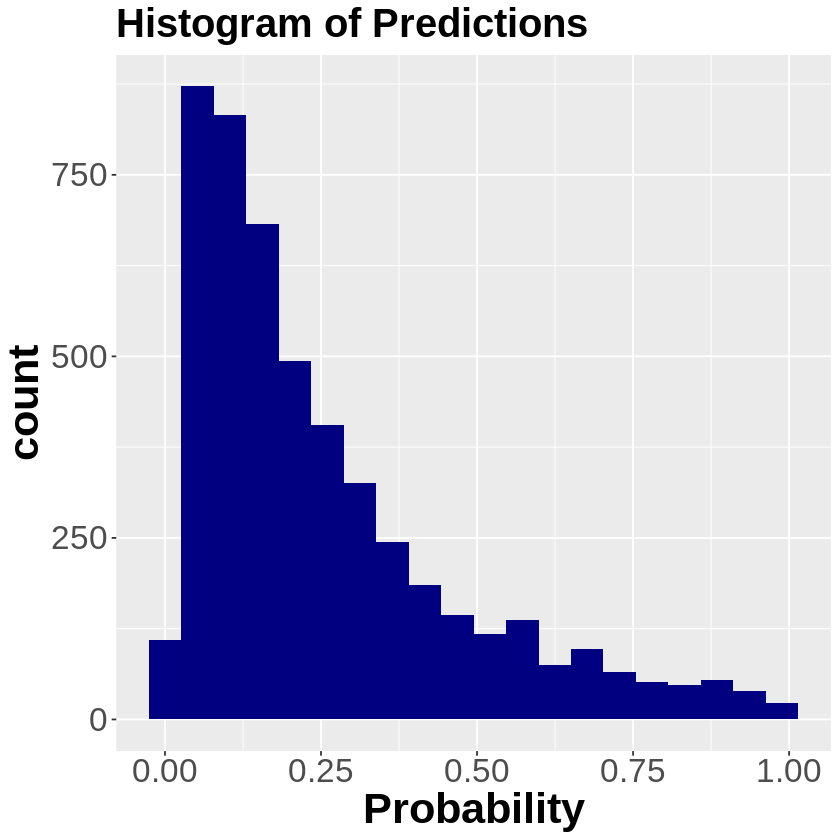

In [318]:
# Histogram of predictions
data.frame(preds = prob_test) %>%
  ggplot(aes(x = prob_test)) + 
  geom_histogram(bins = 20, fill = 'navyblue') +
  labs(title = 'Histogram of Predictions', x = 'Probability') +
  theme( axis.text = element_text(size=20),
         axis.title = element_text(size=26,face = "bold"),
         title = element_text(size = 20,face = "bold")) 

# Range of predictions
paste ("Range of predicted values:")
round(range(prob_test),2)
# Median of predictions
paste ("Median of predicted values:")
round(median(prob_test),2)

# 2. XGBoost  

## One-hot emcoding

In [396]:
dummy <- dummyVars(" ~ .", data = X_train)
X_trainc <- data.frame(predict(dummy, newdata = X_train))
dummy <- dummyVars(" ~ .", data = X_val)
X_valc <- data.frame(predict(dummy, newdata = X_val))
dummy <- dummyVars(" ~ .", data = X_test)
X_testc <- data.frame(predict(dummy, newdata = X_test))

## Principal Component Analysis (PCA) (skipped)

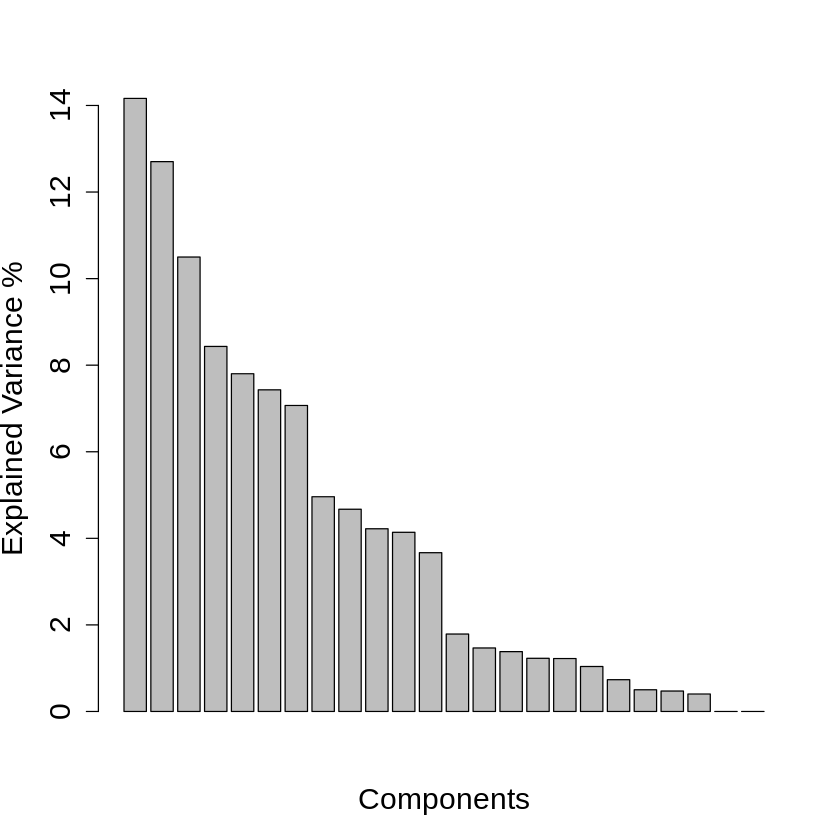

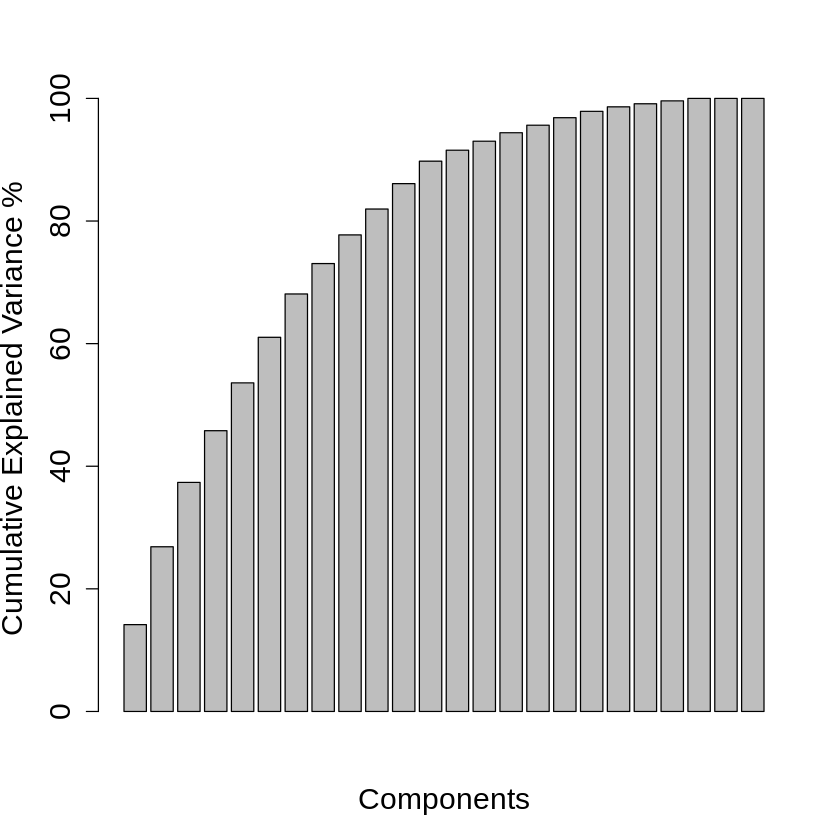

In [244]:
# PCA (skipped) (can be used for dimensional reduction, 
# but feature information lost, included for reference)
train3$RE <- factor(train3$RE)
sparse_matrix <- sparse.model.matrix(DI~.-1, data = train3)
output_vector = train3$DI
sparse_matrix_val <- sparse.model.matrix(DI~.-1, data = val3)
output_vector_val = val3$DI

# PCA scaling the x variables
pca <- prcomp (X_trainc, center = TRUE, scale = TRUE)

# Explained variance %
barplot((pca$sdev)^2/(sum((pca$sdev)^2))*100, xlab = "Components", 
ylab = "Explained Variance %", cex.axis = 1.5, cex.lab = 1.5)

# Cumulative explained variance %
barplot(cumsum((pca$sdev)^2/(sum((pca$sdev)^2))*100), xlab = "Components", 
ylab = "Cumulative Explained Variance %", cex.axis = 1.5, cex.lab = 1.5) 

X_trainc <- pca$x[,1:12] # reduced from 24 to 12 columns

X_valc <- predict(pca, newdata = X_valc)
X_valc <- X_valc[, 1:12]

X_testc <- predict(pca, newdata = X_testc)
X_testc <- X_testc [, 1:12]

## Fit and Train the Model

In [275]:
# Define train, validation, test data
y_train <- train3$DI
y_val <- as.numeric(y_val)
y_test <- as.numeric(y_test)

dtrain = xgb.DMatrix(data = as.matrix(X_trainc), label = y_train)
dval = xgb.DMatrix(data = as.matrix(X_valc), label = y_val)
dtest = xgb.DMatrix(data = as.matrix(X_testc), label = y_test)

# Define watchlist
watchlist = list(train = dtrain, validation = dval)

# Negative & positive cases in the data
negative_cases <- sum(y_train == 0)
postive_cases <- sum(y_train == 1)

# Set XGB parameters 
param <- list(  objective           = "binary:logistic", 
                booster             = "gbtree",
                eval_metric         = "auc",
                eta                 = 0.02,     
                max_depth           = 2,       
                subsample           = 0.95,     
                colsample_bytree    = 0.3,       
                min_child_weight    = 2,    
                num_parallel_tree   = 1        
)

nrounds <- 1500
early.stop.round <- 100

# Fit and tune XGB model
model3 <- xgb.train( params              = param, 
                    data                = dtrain, 
                    nrounds             = nrounds, 
                    verbose             = 1,
                    print_every_n       = 100,
                    early_stopping_rounds = early.stop.round,
                    scale_pos_weight = sqrt(negative_cases/postive_cases),
                    watchlist           = watchlist,
                    maximize            = TRUE)

# Or use grid search to tune the hyperparameters

[1]	train-auc:0.688748	validation-auc:0.675161 
Multiple eval metrics are present. Will use validation_auc for early stopping.
Will train until validation_auc hasn't improved in 100 rounds.

[101]	train-auc:0.838147	validation-auc:0.832037 
[201]	train-auc:0.852207	validation-auc:0.841874 
[301]	train-auc:0.861301	validation-auc:0.848879 
[401]	train-auc:0.866284	validation-auc:0.852674 
[501]	train-auc:0.869720	validation-auc:0.853972 
[601]	train-auc:0.871996	validation-auc:0.855013 
[701]	train-auc:0.874243	validation-auc:0.855978 
[801]	train-auc:0.875952	validation-auc:0.856031 
Stopping. Best iteration:
[752]	train-auc:0.875187	validation-auc:0.856172



In [4]:
# Hyperparameters
inputs <- c("nrounds"=model$bestInd,
            "eta"=param$eta,
            "max_depth"=param$max_depth,
            "subsample"=param$subsample,
            "colsample_bytree"=param$colsample_bytree,
            "min_child_weight"=param$min_child_weight,
            "num_parallel_tree"=param$num_parallel_tree)
paste ("Selected parameters:")
as.table(inputs)

## Model Performance

In [339]:
# Model prediction on training, validation, and test sets
prob_train3 <- predict (model3, dtrain, type = "response")
prob_val3 <- predict (model3, dval, type = "response")
prob_test3 <- predict (model3, dtest, type = "response")
pred.c_train3 <- ifelse(prob_train3 >= 0.5, 1, 0)
pred.c_val3 <- ifelse(prob_val3 >= 0.5, 1, 0)
pred.c_test3 <- ifelse(prob_test3 >= 0.5, 1, 0)

# Confusion matrix 
confusionMatrix(factor(pred.c_train3), factor(y_train), mode = "everything", positive="1")
confusionMatrix(factor(pred.c_val3), factor(y_val), mode = "everything", positive="1")
confusionMatrix(factor(pred.c_test3), factor(y_test), mode = "everything", positive="1")

# Model AUC
paste ("AUC for training set = ", auc(y_train, as.vector(prob_train3)))
paste ("AUC for validation set = ", auc(y_val, as.vector(prob_val3)))
paste ("AUC for test set = ", auc(y_test, as.vector(prob_test3)))

Confusion Matrix and Statistics

          Reference
Prediction     0     1
         0 13742   815
         1   644   799
                                          
               Accuracy : 0.9088          
                 95% CI : (0.9042, 0.9132)
    No Information Rate : 0.8991          
    P-Value [Acc > NIR] : 1.960e-05       
                                          
                  Kappa : 0.4725          
                                          
 Mcnemar's Test P-Value : 8.562e-06       
                                          
            Sensitivity : 0.49504         
            Specificity : 0.95523         
         Pos Pred Value : 0.55371         
         Neg Pred Value : 0.94401         
              Precision : 0.55371         
                 Recall : 0.49504         
                     F1 : 0.52273         
             Prevalence : 0.10088         
         Detection Rate : 0.04994         
   Detection Prevalence : 0.09019         
      Balanced Acc

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 3450  210
         1  164  176
                                          
               Accuracy : 0.9065          
                 95% CI : (0.8971, 0.9153)
    No Information Rate : 0.9035          
    P-Value [Acc > NIR] : 0.27049         
                                          
                  Kappa : 0.4337          
                                          
 Mcnemar's Test P-Value : 0.01997         
                                          
            Sensitivity : 0.4560          
            Specificity : 0.9546          
         Pos Pred Value : 0.5176          
         Neg Pred Value : 0.9426          
              Precision : 0.5176          
                 Recall : 0.4560          
                     F1 : 0.4848          
             Prevalence : 0.0965          
         Detection Rate : 0.0440          
   Detection Prevalence : 0.0850          
      Balanced Accuracy 

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 4070  187
         1  430  313
                                          
               Accuracy : 0.8766          
                 95% CI : (0.8672, 0.8856)
    No Information Rate : 0.9             
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.4362          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.6260          
            Specificity : 0.9044          
         Pos Pred Value : 0.4213          
         Neg Pred Value : 0.9561          
              Precision : 0.4213          
                 Recall : 0.6260          
                     F1 : 0.5036          
             Prevalence : 0.1000          
         Detection Rate : 0.0626          
   Detection Prevalence : 0.1486          
      Balanced Accuracy 

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "AUC for training set =  0.87518732500326"

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "AUC for validation set =  0.85617173857566"

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "AUC for test set =  0.870796666666667"

## Importance of Features

[1] "Feature Importance Table:"

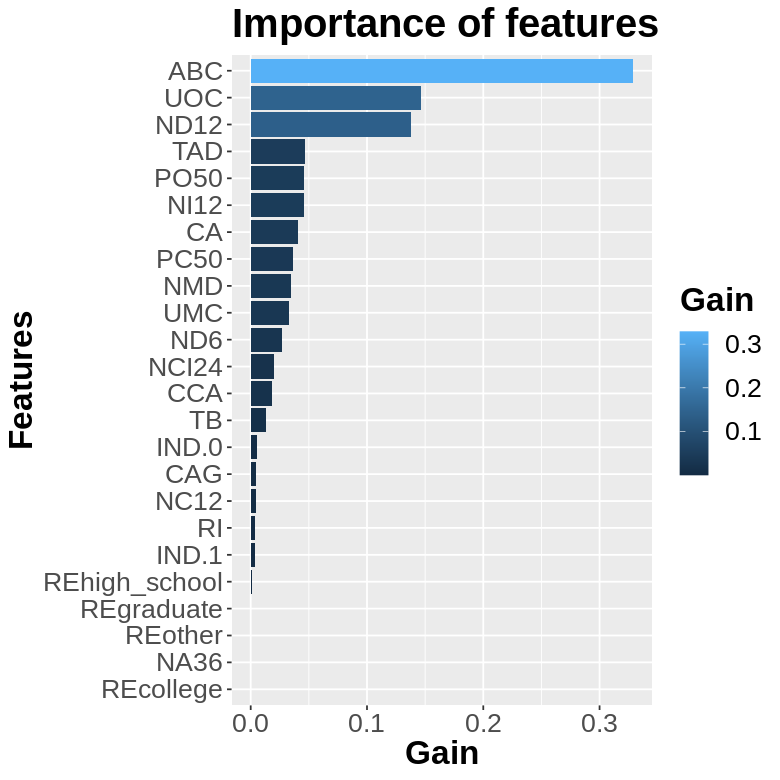

In [392]:
# Method 1: Importance values
imp <- xgb.importance(model = model3)
paste("Feature Importance Table:")

ggplot(imp, aes(x = reorder(Feature, Gain), 
                y = Gain, fill = Gain)) +
  geom_bar(stat='identity') + 
  labs(title = 'Importance of features', x = 'Features', y = 'Gain') +
    coord_flip() + 
    theme( axis.text = element_text(size = 16),
    axis.title = element_text(size = 20,face = "bold"),
    title = element_text(size = 20, face = "bold"),
    legend.text = element_text(size = 16))

# Method 2: SHAP (SHapley Additive exPlanations) below

## Individual Variable Effect 

In [397]:
# method 1: Partial dependence plot (PDP), For example, for UOC and IND.1:
pd1 <- partial(model3, pred.var = c("UOC"), plot = FALSE,prob = T, train = X_trainc)
pd2 <- partial(model3, pred.var = c("IND.1"), plot = FALSE,prob = T, train = X_trainc)

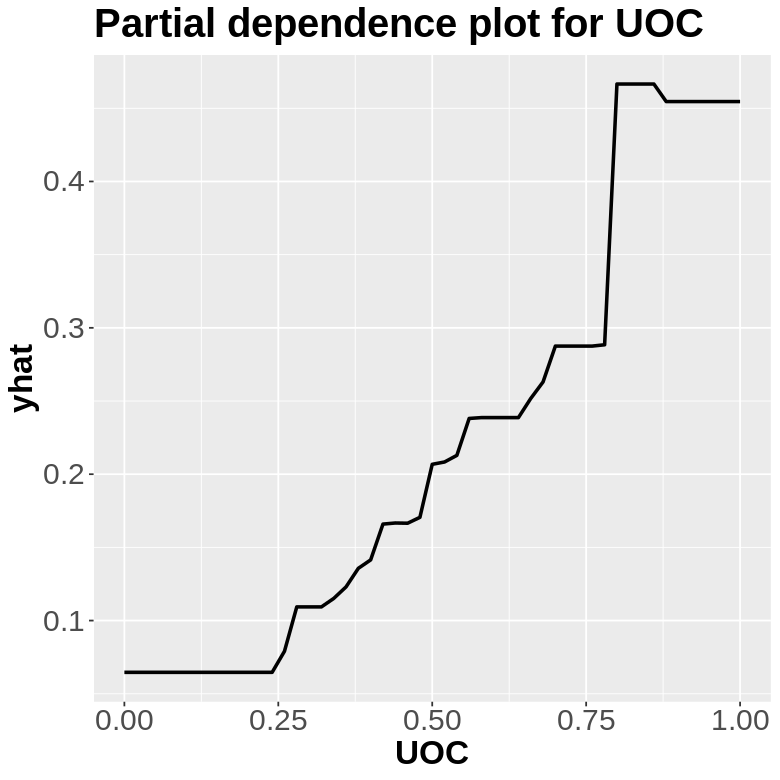

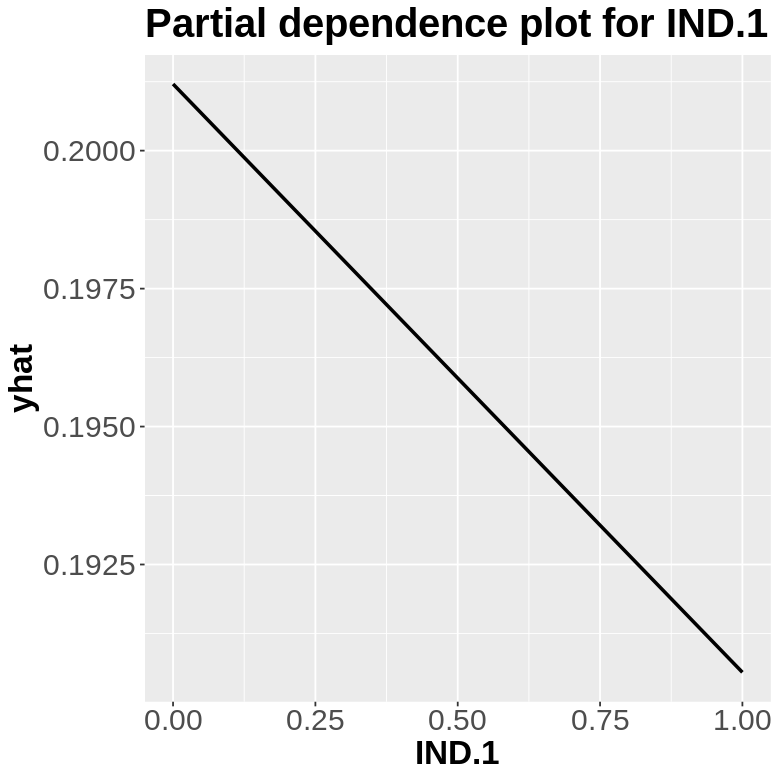

In [382]:
options(repr.plot.width = 6.5, repr.plot.height = 6.5)
p1 <- autoplot(pd1, contour = TRUE, main = "Partial dependence plot for UOC", size = 1) +
  theme(title = element_text(size = 20,face = "bold"), axis.text = element_text(size = 18))
p2 <- autoplot(pd2, contour = TRUE, main = "Partial dependence plot for IND.1", size = 1)+
  theme(title = element_text(size = 20,face = "bold"), axis.text = element_text(size = 18))
p1
p2

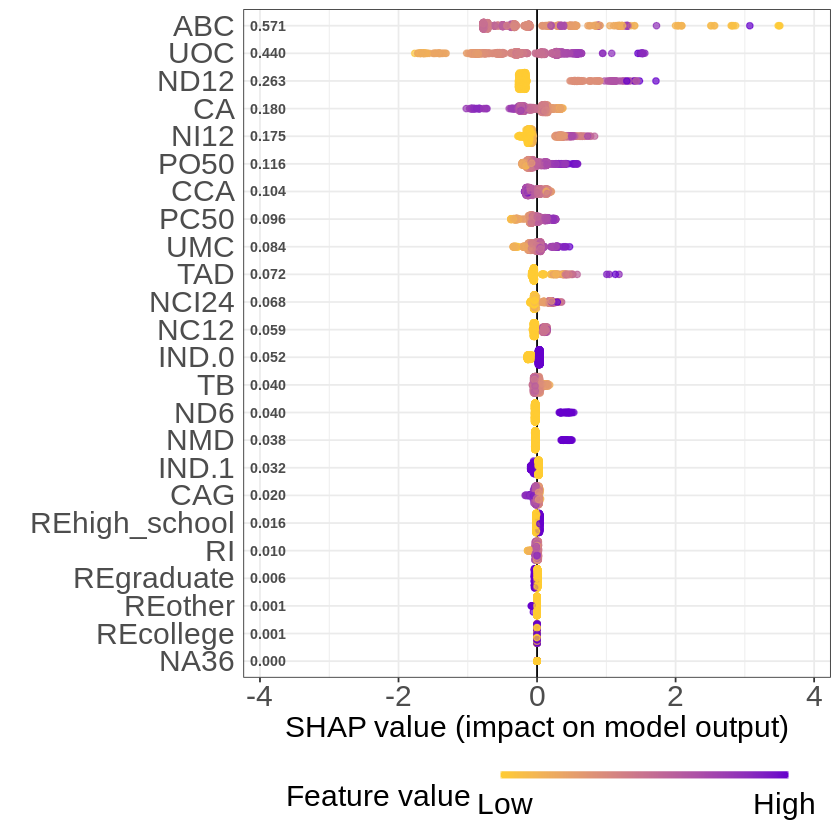

In [288]:
# Method 2: SHAP summary plots - feature importance with feature effects
# Step 1: Select some observations
X <- data.matrix(X_trainc[sample(nrow(X_trainc), 1000), ]) 

# Step 2: Crunch SHAP values
shap <- shap.prep(model3, X_train = X)

# Step 3: SHAP importance

shap.plot.summary(shap) + ggplot2::theme(axis.line.y = element_blank(),
      axis.ticks.y = element_blank(), legend.position = "bottom",
      legend.title = element_text(size = 18),
      legend.text = element_text(size = 18), 
      axis.title.x = element_text(size = 18),
      axis.text.y = element_text(size = 18),
      axis.text.x.bottom = element_text(size  = 18))

In [ ]:
# Step 4: Loop over SHAP dependence plots in decreasing importance
for (v in shap.importance(shap, names_only = TRUE)) {
  p <- shap.plot.dependence(shap, v, color_feature = "auto", 
                            alpha = 0.5, jitter_width = 0.1) +
    ggtitle(v)
  print(p)
}

In [ ]:
# Show one of the trees
xgb.plot.multi.trees(feature_names = names(data.matrix(X_trainc)), model = model3)

## Distribution of Predicted Values

[1] "Range of predictions:"

[1] 0 1

[1] "Median of predictions:"

[1] 0.16

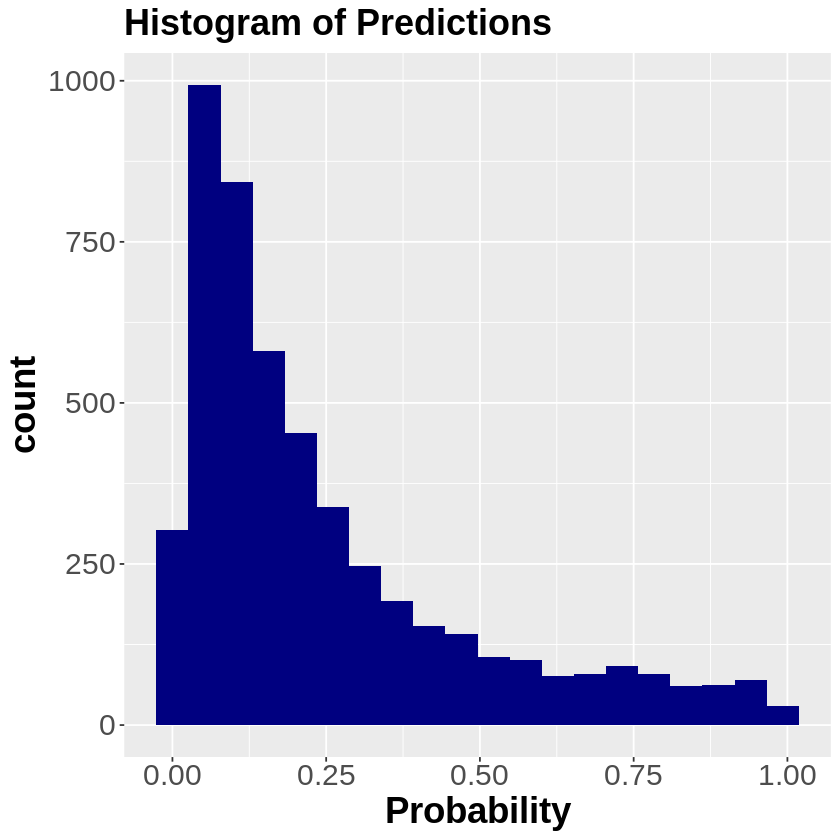

In [317]:
# Histogram of predictions
data.frame(preds = prob_test3) %>%
  ggplot(aes(x = prob_test3)) + 
  geom_histogram(bins = 20, fill = 'navyblue') +
  labs(title = 'Histogram of Predictions', x = 'Probability') +
  theme(axis.title.x = element_text(size = 22),
      axis.title.y = element_text(size  = 22),
      axis.text.y = element_text(size = 18),
      axis.text.x = element_text(size  = 18),
      title = element_text(size  = 18, face="bold"))

# Range of predictions
paste ("Range of predictions:")
round(range(prob_test3),2)
# Median of predictions
paste ("Median of predictions:")
round(median(prob_test3),2)

# Summary

In this project, I used logistic regression and XGBoost algorithm to build binary classification models for predicting default account. The classes are highly imbalanced, so class weights were applied for both models. The logistic regression model was built with two feature selection methods: lasso regression and step-wise selection. Both lead to similar model performance as shown in the table below. The logistic regression model with lasso regularization has 15 features selected while it with step-wise selection has 14 features. Compared to the logistic regression model, the XGBoost perfoms better in predicting both classes with a higher precison ($0.421 > 0.333$) and recall ($0.626 > 0.474$). It also shows an higher model accuracy ($0.877 > 0.853$), $F1$ ($0.504 > 0.391$), $AUC$ ($0.871 > 0.791$). This may due to two reasons: (1) The logistic regression models have fewer features included and less data information utilized, and (2) logistic regression has the linearity assumption between the log-odds and the predictors, it shows poor model performance for non-linear data. On the other hand, XGBoost algorithem is tree-based, it works well with both linear or non-linear data.

<br>

| Model | Accuracy | F1 | AUC | Precision | Recall |
| --- | --- |--- |--- | --- |--- |
| Logistic regression (lasso) | 0.855 | 0.390 | 0.791 | 0.336 | 0.464 |
| Logistic regression (stepwise) | 0.853 | 0.391 | 0.791 | 0.333 | 0.474 |
| XGBoost | 0.877 | 0.504 | 0.871 | 0.421 | 0.626 |

<br>

However, it is much easier to apply logistic regression than to use XGBoost since the latter one involves tuning many hyperparameters. And logistic regression models can be easily interpreted with the coefficients of the predictors. For example, from the final logistic regression (lasso) model shown below, it is seen applicants who already have accounts in the bank ($IND_1$) are less likely to have a default account than their counterparts.

\begin{equation}
\begin{split}
log(\frac{\hat{p}}{1-\hat{p}})&= -2.21 - 0.000120* ABC - 0.00487*CA +0.000779*CAG\dots  \\&-0.331*IND_1 -0.178*RE_{graduate} +0.128 *RE_{highschool} - 0.637 *RE_{other}.
\\
\end{split}
\end{equation}